# A2: Predicting Car Price
## Aphisit Jaemyaem - st126130

In [1]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import joblib
import warnings
warnings.filterwarnings('ignore')

## Preparing data

In [40]:
dt = pd.read_csv("../data/Cars.csv")

In [41]:
#cleansing data (from A1 predicting car price)
Owner_map = {"First Owner": 1,"Second Owner": 2,"Third Owner": 3,"Fourth & Above Owner": 4,"Test Drive Car": 5}
dt['owner']=dt['owner'].map(Owner_map)
dt = dt[(dt['fuel'] != 'CNG') & (dt['fuel'] != 'LPG')]
dt['mileage']=dt['mileage'].str.split().str[0].astype(float)
dt['engine']=dt['engine'].str.split().str[0].astype(float)
dt['max_power']=dt['max_power'].str.split().str[0].astype(float)
dt['name']=dt['name'].str.split().str[0]
dt = dt.rename(columns={'name':'brand'})
dt=dt.drop(columns =['torque'])
dt = dt[(dt['owner'] != 5)]
dt= pd.get_dummies(dt, columns=['fuel','transmission','seller_type','owner'],drop_first=True)
X = dt.drop(columns=['selling_price','engine','seats','brand']) 
y = dt['selling_price']

In [42]:
#split train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [43]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [44]:
X_train['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_train['mileage'].fillna(X_train['mileage'].median(), inplace=True)
X_test['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_test['mileage'].fillna(X_train['mileage'].median(), inplace=True)

In [45]:
X_train.isna().sum()

year                            0
km_driven                       0
mileage                         0
max_power                       0
fuel_Petrol                     0
transmission_Manual             0
seller_type_Individual          0
seller_type_Trustmark Dealer    0
owner_2                         0
owner_3                         0
owner_4                         0
dtype: int64

In [46]:
from sklearn.preprocessing import StandardScaler

num_features = ['year','km_driven','mileage','max_power']


scaler = StandardScaler()
X_train = X_train.copy() 
X_test  = X_test.copy()

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features]  = scaler.transform(X_test[num_features])

In [47]:
X_train = X_train.to_numpy(dtype=float)
y_train = y_train.to_numpy(dtype=float).ravel()
X_test = X_test.to_numpy(dtype=float)
y_test = y_test.to_numpy(dtype=float).ravel()

## **Task 1. Implementation**

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment(experiment_name="Car price prediction")

In [49]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

class LinearRegression(object):
    
    kfold = KFold(n_splits=3)
        
    def __init__(self,
        regularization=None,
        lr=0.001,
        method='batch',
        weight_init_mode='zeros',
        use_momentum=True,
        momentum=0.9,
        degree=1, #for polynomial features
        num_epochs=500,
        batch_size=50,
        cv=kfold,):
        self.regularization = regularization
        self.lr         = lr
        self.method     = method
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.cv         = cv 
        self.weight_init_mode = weight_init_mode
        self.use_momentum   = use_momentum
        self.momentum   = momentum
        self.degree = degree
        self.prev_step = 0
#metrics 
    #function mse that compute the mse score
    def mse(self, ytrue, ypred):
        ytrue = np.asarray(ytrue, dtype=float).reshape(-1)   #(m,)
        ypred = np.asarray(ypred, dtype=float).reshape(-1)
        m = ytrue.size
        if m == 0:
            raise ValueError("Empty ytrue in mse")
        else:
            return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0] 
    
    #add a function r2 that compute the r2 score 
    def r2(self, ytrue, ypred):
        ss_res = np.sum((ytrue - ypred) ** 2)
        ss_tot = np.sum((ytrue - ytrue.mean()) ** 2)
        r2_score = 1.0 - (ss_res / ss_tot)
        return r2_score
#initializers
    #add a function xavier initialization method to calculated as a random number with uniform prob dist 
    def xavier_init(self,n_input,n_output):
        lower,upper = -(1.0/np.sqrt(n_input)), (1.0/np.sqrt(n_input))
        numbers = np.random.rand(n_output)
        scaled =lower + numbers*(upper-lower)
        return scaled

    def fit(self, X_train, y_train):
        
        self.kfold_scores = list()
        #reset val loss
        self.val_loss_old = np.inf
        #cross-validation
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            

            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]

            if self.degree > 1:
                X_cross_train = self.polynomial_features(X_cross_train, self.degree)
                X_cross_val = self.polynomial_features(X_cross_val, self.degree)

            if self.weight_init_mode in ('zero', 'zeros'):
                self.theta = np.zeros(X_cross_train.shape[1])
            elif self.weight_init_mode in ('xavier', 'xavier_init', 'xavier_weigh_init'):
                self.theta = self.xavier_init(X_cross_train.shape[0],X_cross_train.shape[1])
            else: 
                raise ValueError(f"unknown weight_init: {self.weight_init_mode}")

            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            
            
            #one epoch will exhaust the WHOLE training set
            with mlflow.start_run(run_name=f"Fold-{fold}", nested=True):
                
                params = {"method": self.method, "lr": self.lr, "reg": type(self).__name__}
                mlflow.log_params(params=params)
                
                for epoch in range(self.num_epochs):
                
                    #with replacement or no replacement
                    #with replacement means just randomize
                    #with no replacement means 0:50, 51:100, 101:150, ......300:323
                    #shuffle your index
                    perm = np.random.permutation(X_cross_train.shape[0])
                            
                    X_cross_train = X_cross_train[perm]
                    y_cross_train = y_cross_train[perm]
                    
                    if self.method == 'stochastic':
                        for batch_idx in range(X_cross_train.shape[0]):
                            X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                            y_method_train = y_cross_train[[batch_idx]] 
                            train_loss = self._train(X_method_train, y_method_train)
                    elif self.method == 'mini-batch':
                        for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                            #batch_idx = 0, 50, 100, 150
                            X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                            y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                            train_loss = self._train(X_method_train, y_method_train)
                    else: #batch
                        X_method_train = X_cross_train
                        y_method_train = y_cross_train
                        train_loss = self._train(X_method_train, y_method_train)

                    mlflow.log_metric(key="train_loss", value=train_loss, step=epoch)

                    yhat_val = self.predict(X_cross_val)
                    val_loss_new = self.mse(y_cross_val, yhat_val)
                    val_r2 = self.r2(y_cross_val, yhat_val)
                    mlflow.log_metric(key="val_loss", value=val_loss_new, step=epoch)
                    mlflow.log_metric(key="val_r2", value=val_r2, step=epoch)
                    #early stopping
                    if np.allclose(val_loss_new, self.val_loss_old):
                        break
                    self.val_loss_old = val_loss_new
            
                self.kfold_scores.append(val_loss_new)
                print(f"Fold {fold}: MSE Score - {val_loss_new}, R2 Score - {val_r2}")
    
    #update
    def _train(self, X, y):
        yhat = self.predict(X)
        m    = X.shape[0]
        
        if self.regularization is not None:
            reg_grad = self.regularization.derivation(self.theta)
        else: reg_grad = 0        
        grad = (1/m) * X.T @(yhat - y) + reg_grad
        #add momentum from pseudocode
        if self.use_momentum:
            step = self.lr*grad
            self.theta = self.theta - step + self.momentum*self.prev_step 
            self.prev_step = step
        else:
            self.theta = self.theta - self.lr * grad
        return self.mse(y, yhat)
    
    def predict(self, X, poly=False):
        if X.ndim == 1:
            X = X.reshape(1, -1)                 # (1, n)
        if poly and self.degree > 1:
            X = self.polynomial_features(X, self.degree)
        return X @ self.theta

    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercept
                               #w1....wn are the weights / coefficients / theta
    def _bias(self):
        return self.theta[0]
    
    #polynomial features
    def polynomial_features(self,X, degree):
        X_poly = np.ones((X.shape[0], 1))  
        for d in range(1, degree + 1):
            X_poly = np.hstack((X_poly, X ** d))
        return X_poly

In [50]:
class LassoPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta)
    
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
        
    def derivation(self, theta):
        return self.l * 2 * theta
    
class Lasso(LinearRegression):
    
    def __init__(self, method, lr, l,weight_init_mode,use_momentum):
        self.regularization = LassoPenalty(l)
        super().__init__(self.regularization, lr, method,weight_init_mode,use_momentum)
        
class Ridge(LinearRegression):
    
    def __init__(self, method, lr, l,weight_init_mode,use_momentum):
        self.regularization = RidgePenalty(l)
        super().__init__(self.regularization, lr, method,weight_init_mode,use_momentum)

class Polynomial(LinearRegression):
    def __init__(self, method='batch', lr=0.001, weight_init_mode='zeros',use_momentum=True, momentum=0.9, degree=2):
        super().__init__(regularization=None,lr=lr,method=method,weight_init_mode=weight_init_mode, use_momentum=use_momentum,momentum=momentum,degree=degree)

## Task 2 Expirement

In [35]:
import sys
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

## MLflow

In [15]:
regs = ["Polynomial","Ridge", "Lasso","LinearRegression"] #(1) polynomial, lasso, ridge, normal
momentums=[True,False]  #(2) with or without momentum
methods =['stochastic', 'mini-batch', 'batch'] #(3) stochastic, mini-batch, batch
weights =['zeros', 'xavier'] #(4) zero, xavier
learning_rates = [0.01, 0.001, 0.0001] #(5) learning rates
best_mse = float("inf")
i=0
#for loop order (4 regs -> 3 methods -> 3 learning rates -> 2 weights -> with or without momentum)
for reg in regs:
    for lr in learning_rates:
         for method in methods:
                  for weight in weights:
                        for momentum in momentums:

                            if reg == 'Polynomial':
                                params = {'method': method, 'lr': lr,'weight_init_mode':weight,'use_momentum':momentum ,'degree': 2} 
                            elif reg == 'Ridge': # l = lambda
                                params = {'method': method, 'lr': lr, 'l': 0.1,'weight_init_mode':weight,'use_momentum':momentum}
                            elif reg == 'Lasso': # l = lambda
                                params = {'method': method, 'lr': lr, 'l': 0.1,'weight_init_mode':weight,'use_momentum':momentum}
                            else: #LinearRegression
                                params = {'method': method, 'lr': lr,'weight_init_mode':weight,'use_momentum':momentum}

                            mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-weight_init_mode-{params['weight_init_mode']}-use_momentum-{params['use_momentum']}-reg-{reg}", nested=True)
                            print("="*5, reg, "="*5)

    
                            type_of_regression = str_to_class(reg)    #Ridge, Lasso, Polynomial, LinearRegression
                            model = type_of_regression(**params)  
                            model.fit(X_train, y_train)
                            
                            if reg == 'Polynomial':
                                 poly = True
                            else:
                                 poly = False
                                 
                            yhat = model.predict(X_test,poly)
                            mse  = model.mse(y_test, yhat)
                            r2_score   = model.r2(y_test, yhat)

                            print("Test MSE: ", mse)
                            print("Test R2: ", r2_score)
                            mlflow.log_metric(key="test_mse", value=mse)
                            mlflow.log_metric(key="test_r2", value=r2_score)

                            if mse < best_mse:
                                signature = mlflow.models.infer_signature(X_train, model.predict(X_train, poly))

                                logged_model = mlflow.sklearn.log_model(
                                    model,
                                    artifact_path=f"model",
                                    signature=signature,
                                    registered_model_name=f"model{i}")
                                i += 1
                                best_mse = mse

                                joblib.dump(model, f"method-{params['method']}-lr-{params['lr']}-weight_init_mode-{params['weight_init_mode']}-use_momentum-{params['use_momentum']}-reg-{reg}.joblib")

                        mlflow.end_run()

===== Polynomial =====
Fold 0: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/176410324244826153/runs/cc58962c2bfd4cf4aa08436a46861625
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Fold 1: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/176410324244826153/runs/78f3b4a28522470da3b0a79291fe7735
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Fold 2: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/176410324244826153/runs/b2d92822d48b43ddba956dfe4975f6c6
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Test MSE:  inf
Test R2:  -inf
===== Polynomial =====
Fold 0: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/176410324244826153/runs/1d7003debefa46bb926c2f6bdc4d1c17
🧪 View experiment at: http://localhost:5000/#/experiments/17641032424

2025/09/12 11:36:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Fold 2: MSE Score - 3.460195803809411e+82, R2 Score - -4.9828430928783446e+82
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/176410324244826153/runs/30dad062d358442aa2162826259598f4
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Test MSE:  7.549217636066139e+79
Test R2:  -1.0729617484217485e+80


Registered model 'model0' already exists. Creating a new version of this model...
2025/09/12 11:36:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model0, version 5
Created version '5' of model 'model0'.


🏃 View run method-mini-batch-lr-0.01-weight_init_mode-zeros-use_momentum-False-reg-Polynomial at: http://localhost:5000/#/experiments/176410324244826153/runs/da632699ce6548a9875c441cb3583515
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
===== Polynomial =====
Fold 0: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/176410324244826153/runs/a05454caa929414baf383d7933287469
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Fold 1: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/176410324244826153/runs/b43a1b3733f04e7792bd570cad69ccf0
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Fold 2: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/176410324244826153/runs/8fc7ad1ce15d46df9b2338f5dad7029c
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Test MSE: 

2025/09/12 11:37:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Fold 2: MSE Score - 14.408090944176276, R2 Score - -19.748321919734398
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/176410324244826153/runs/261c744bb7494dada54c818da963387d
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Test MSE:  15.939296934556882
Test R2:  -21.654342121241946


Registered model 'model1' already exists. Creating a new version of this model...
2025/09/12 11:38:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model1, version 3
Created version '3' of model 'model1'.


===== Polynomial =====
Fold 0: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/176410324244826153/runs/8f5932a82df64414a15def7fabc35cc1
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Fold 1: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/176410324244826153/runs/08b7096d530c45fbbf31da6aee714259
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153


2025/09/12 11:39:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Fold 2: MSE Score - 3.9942880308516795, R2 Score - -4.751960771579561
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/176410324244826153/runs/d0347e695ef0480f90cff9056c648cda
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Test MSE:  4.284207389089759
Test R2:  -5.089095416772866


Registered model 'model2' already exists. Creating a new version of this model...
2025/09/12 11:39:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model2, version 3
Created version '3' of model 'model2'.


🏃 View run method-batch-lr-0.01-weight_init_mode-zeros-use_momentum-False-reg-Polynomial at: http://localhost:5000/#/experiments/176410324244826153/runs/86312a80640449c382eafd8e26b25d7d
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
===== Polynomial =====
Fold 0: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/176410324244826153/runs/398965ae1dab43d8b520167630c015e5
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Fold 1: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/176410324244826153/runs/c6e432a540eb4d14908f44c11778503e
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Fold 2: MSE Score - 14.350052823948596, R2 Score - -19.664744323870675
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/176410324244826153/runs/4394bf52c9454143b8b3cf2a140bbdf0
🧪 View experiment at: http://localhost:5000/#/experiments/1764

2025/09/12 11:41:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Fold 2: MSE Score - 3.9864162353762507, R2 Score - -4.740625019518909
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/176410324244826153/runs/4d4e0d396aba40718c7e9dd6ddf66a99
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Test MSE:  4.2761572280502405
Test R2:  -5.077653814105627


Registered model 'model3' already exists. Creating a new version of this model...
2025/09/12 11:41:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model3, version 3
Created version '3' of model 'model3'.


🏃 View run method-batch-lr-0.01-weight_init_mode-xavier-use_momentum-False-reg-Polynomial at: http://localhost:5000/#/experiments/176410324244826153/runs/897557a9b05645028ec9f68ce1ade1ab
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
===== Polynomial =====
Fold 0: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/176410324244826153/runs/d2abf5d9d18f4098ad57543f7b8c9872
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Fold 1: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/176410324244826153/runs/bb5fc7577ee1432096568966a44422af
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Fold 2: MSE Score - inf, R2 Score - -inf
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/176410324244826153/runs/1ed87c993b254df99a0facdfe2e16f00
🧪 View experiment at: http://localhost:5000/#/experiments/176410324244826153
Test MSE:  inf

### Perform the prediction on the test set

In [51]:
best_model = joblib.load('method-batch-lr-0.01-weight_init_mode-xavier-use_momentum-False-reg-Polynomial.joblib')

In [52]:
y_pred=best_model.predict(X_test,True)
y_pred

array([12.82661759, 14.06262702, 13.1518727 , ..., 11.83491208,
       13.67542873, 13.85056552], shape=(2409,))

In [53]:
y_pred = np.exp(y_pred)

In [54]:
y_pred

array([ 371988.26621838, 1280328.21861982,  514974.51610003, ...,
        137986.63125459,  869287.10349253, 1035676.63308913],
      shape=(2409,))

In [56]:
y_test=np.exp(y_test)

In [57]:
y_test

array([225000., 900000., 320000., ..., 150000., 650000., 300000.],
      shape=(2409,))

In [ ]:
#display mse and r2
mse = best_model.mse(y_test, y_pred)
r2  = best_model.r2(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R² : {r2:.4f}")

### Feature importance

In [58]:
coefs = best_model._coef()
print(coefs)

[ 1.25706601 -0.09521258  0.12593619  1.16826513  0.72752792  2.24233199
  1.40295171  0.58442913  0.33751488  0.18003627  0.06296529  0.27919168
  0.00588243  0.28942599  0.3064238   0.69982129  2.22745491  1.41581406
  0.56407736  0.33921204  0.17016865  0.0649241 ]


In [59]:
coefs = np.ravel(best_model._coef())
BASE_FEATURES = [
    "year", "km_driven", "mileage", "max_power",
    "fuel_Petrol", "transmission_Manual",
    "seller_type_Individual", "seller_type_Trustmark Dealer",
    "owner_2", "owner_3", "owner_4"]

In [60]:
def guess_degree_bias(n_coefs: int, n_base: int):
    for deg in range(1, 6):             
        for inc_bias in (False, True):  
            expect = (deg * n_base) + (1 if inc_bias else 0)
            if expect == n_coefs:
                return deg, inc_bias
    return None, None

DEGREE, INCLUDE_BIAS = guess_degree_bias(len(coefs), len(BASE_FEATURES))
print(f"degree = {DEGREE}, include_bias = {INCLUDE_BIAS}")

degree = 2, include_bias = False


In [61]:
def my_poly_feature_names(base_feats, degree, include_bias=True):
    names = []
    if include_bias:
        names.append("bias")
    for d in range(1, degree + 1):
        for f in base_feats:
            names.append(f if d == 1 else f"{f}^{d}")
    return names

feature_names = my_poly_feature_names(BASE_FEATURES, DEGREE, INCLUDE_BIAS)

                         feature      coef  abs_coef
5            transmission_Manual  2.242332  2.242332
6         seller_type_Individual  1.402952  1.402952
0                           year  1.257066  1.257066
3                      max_power  1.168265  1.168265
4                    fuel_Petrol  0.727528  0.727528
7   seller_type_Trustmark Dealer  0.584429  0.584429
8                        owner_2  0.337515  0.337515
9                        owner_3  0.180036  0.180036
2                        mileage  0.125936  0.125936
1                      km_driven -0.095213  0.095213
10                       owner_4  0.062965  0.062965


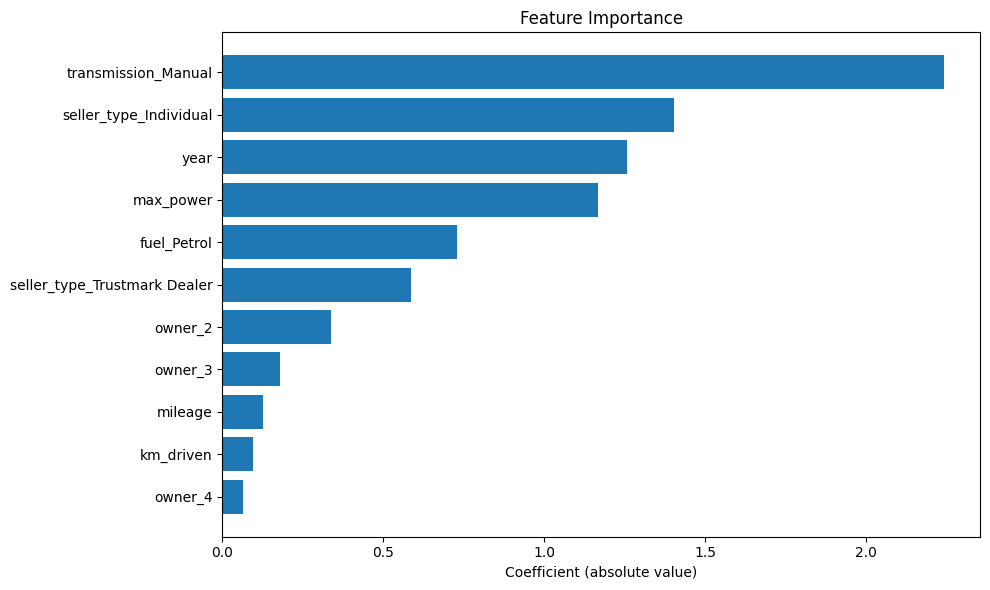

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

df_imp = (pd.DataFrame({"feature": feature_names, "coef": coefs})
            .assign(abs_coef=lambda d: d["coef"].abs()))
df_linear = df_imp[~df_imp["feature"].str.contains(r"\^")]

df_linear = df_linear.sort_values("abs_coef", ascending=False)

print(df_linear)

# plot
plt.figure(figsize=(10,6))
plt.barh(df_linear["feature"], df_linear["abs_coef"])
plt.gca().invert_yaxis()
plt.xlabel("Coefficient (absolute value)")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


## MLflow

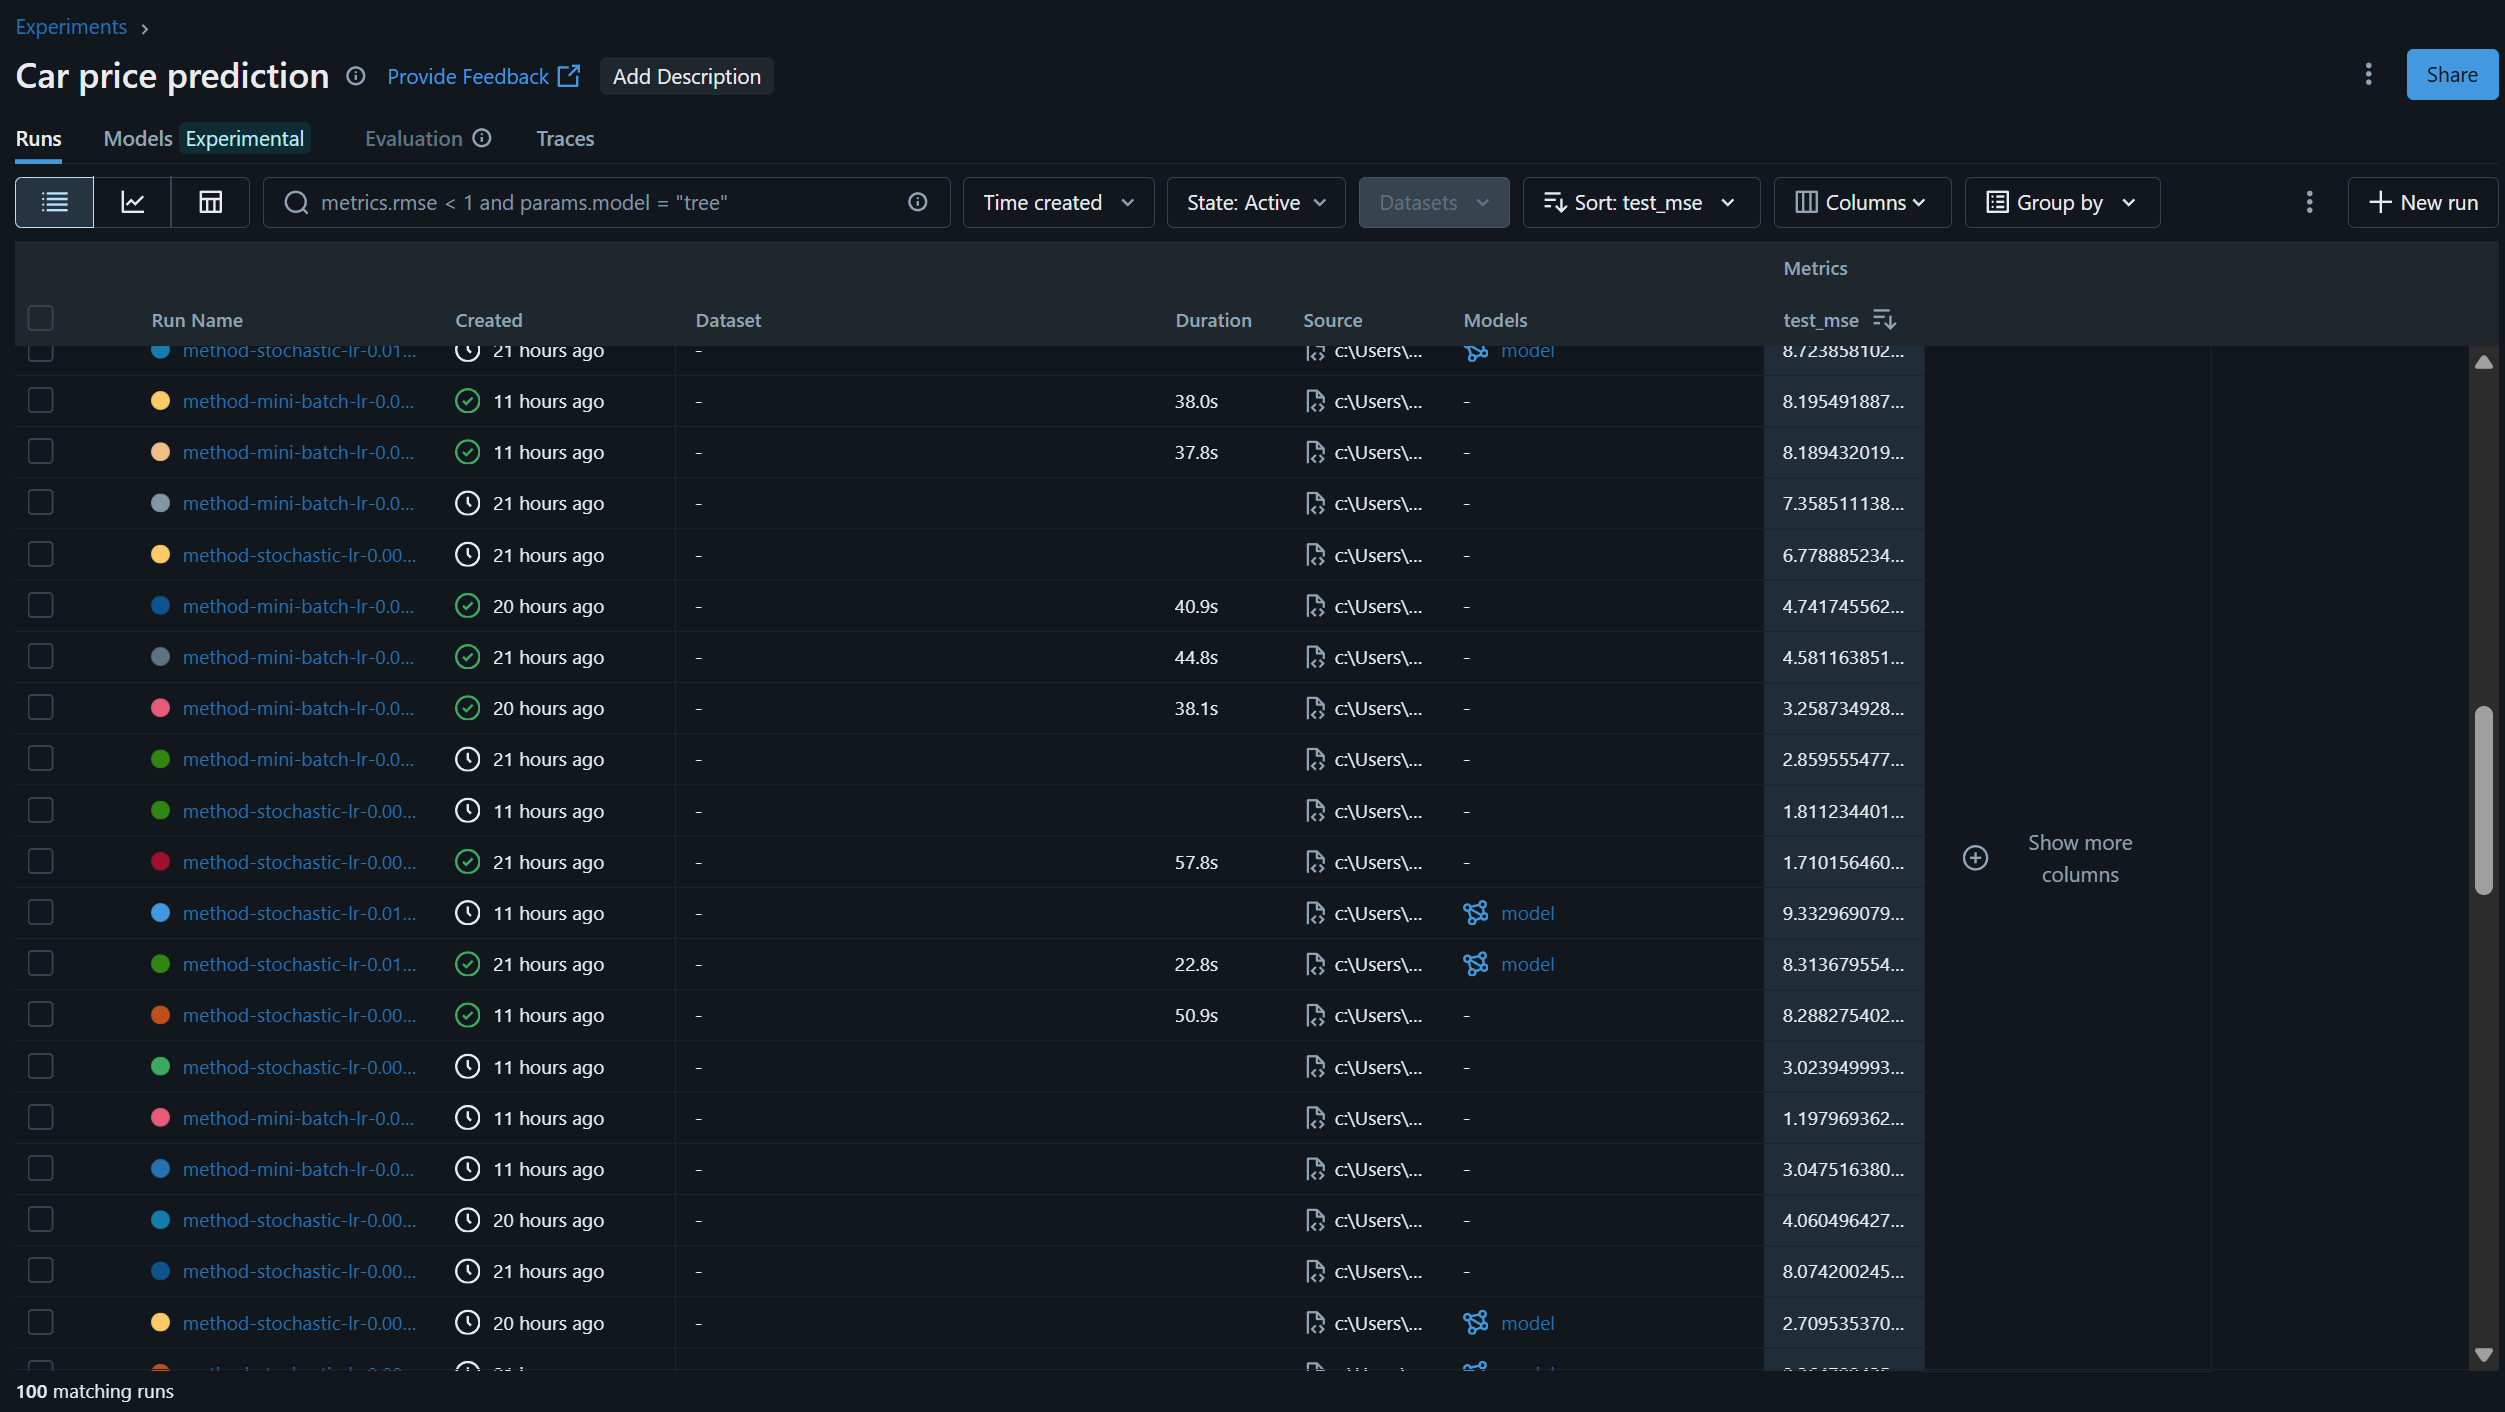

In [2]:
display(Image("assets/mlflow.png"))


# **Report and Discussion**
### 1. Feature Importance (Polynomial)

The chart above shows the feature importance (measured by the absolute values of the regression coefficients) derived from the **Polynomial model**.

**Observations:**
- **`transmission_Manual`** has the largest coefficient magnitude, indicating that the type of transmission (manual vs. automatic) plays the most significant role in predicting car prices.
- **`seller_type_Individual`** and **`year`** follow, suggesting that the seller type (individual vs. dealer) and the car’s manufacturing year strongly.
- **`max_power`** and **`fuel_Petrol`** also contribute substantially, reflecting the importance of engine power and fuel type.
- Other features such as **`owner_2`**, **`mileage`**, and **`km_driven`** have smaller coefficients, meaning they have less impact on the model compared to the top features.


### 2. Result discussion/finding

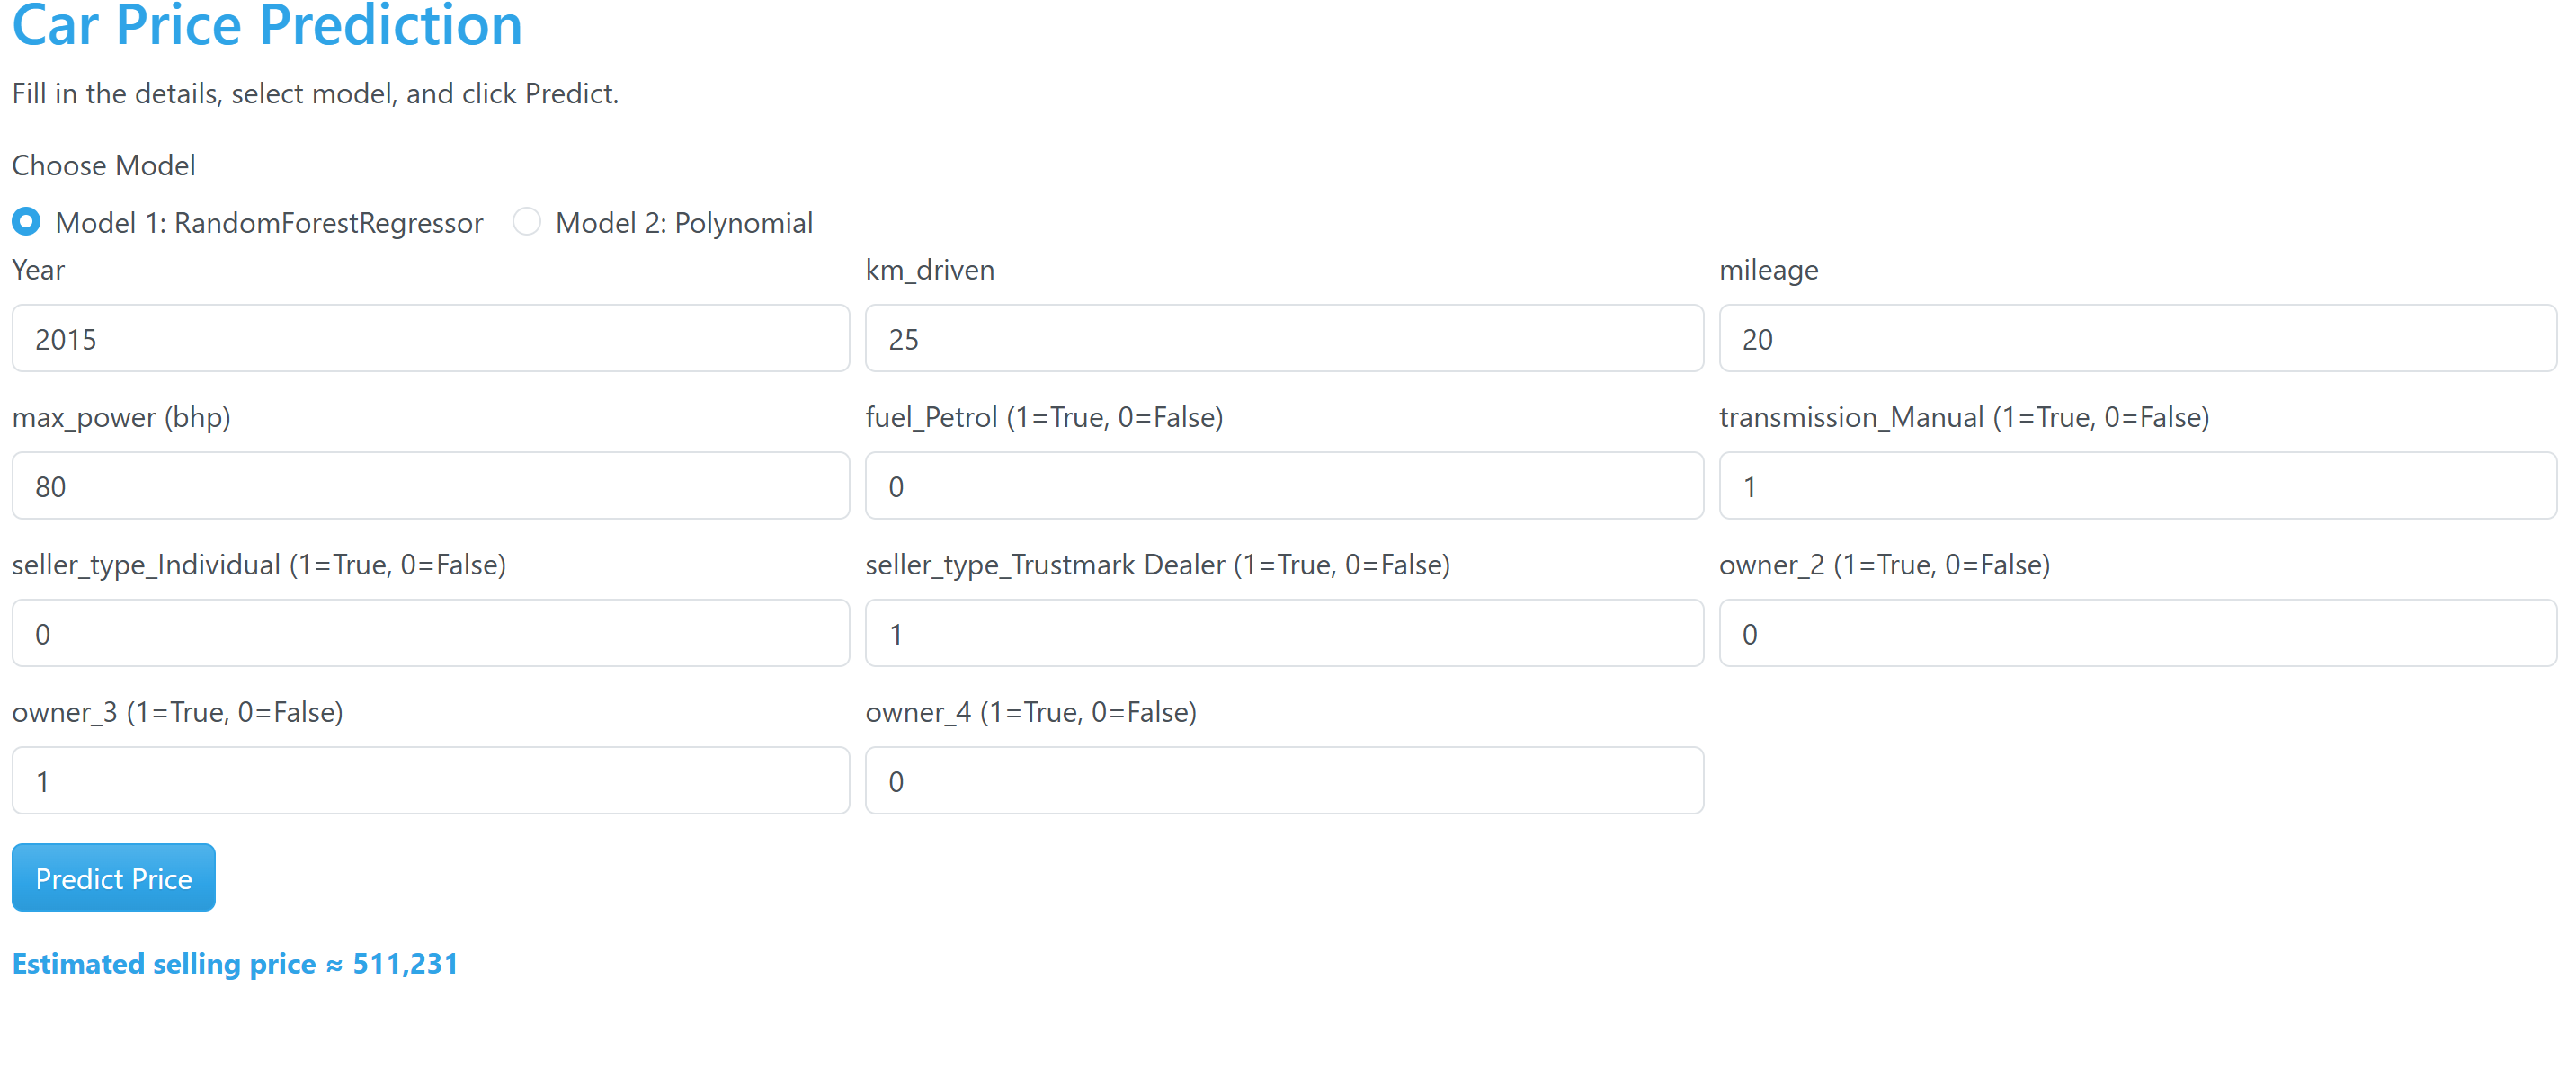

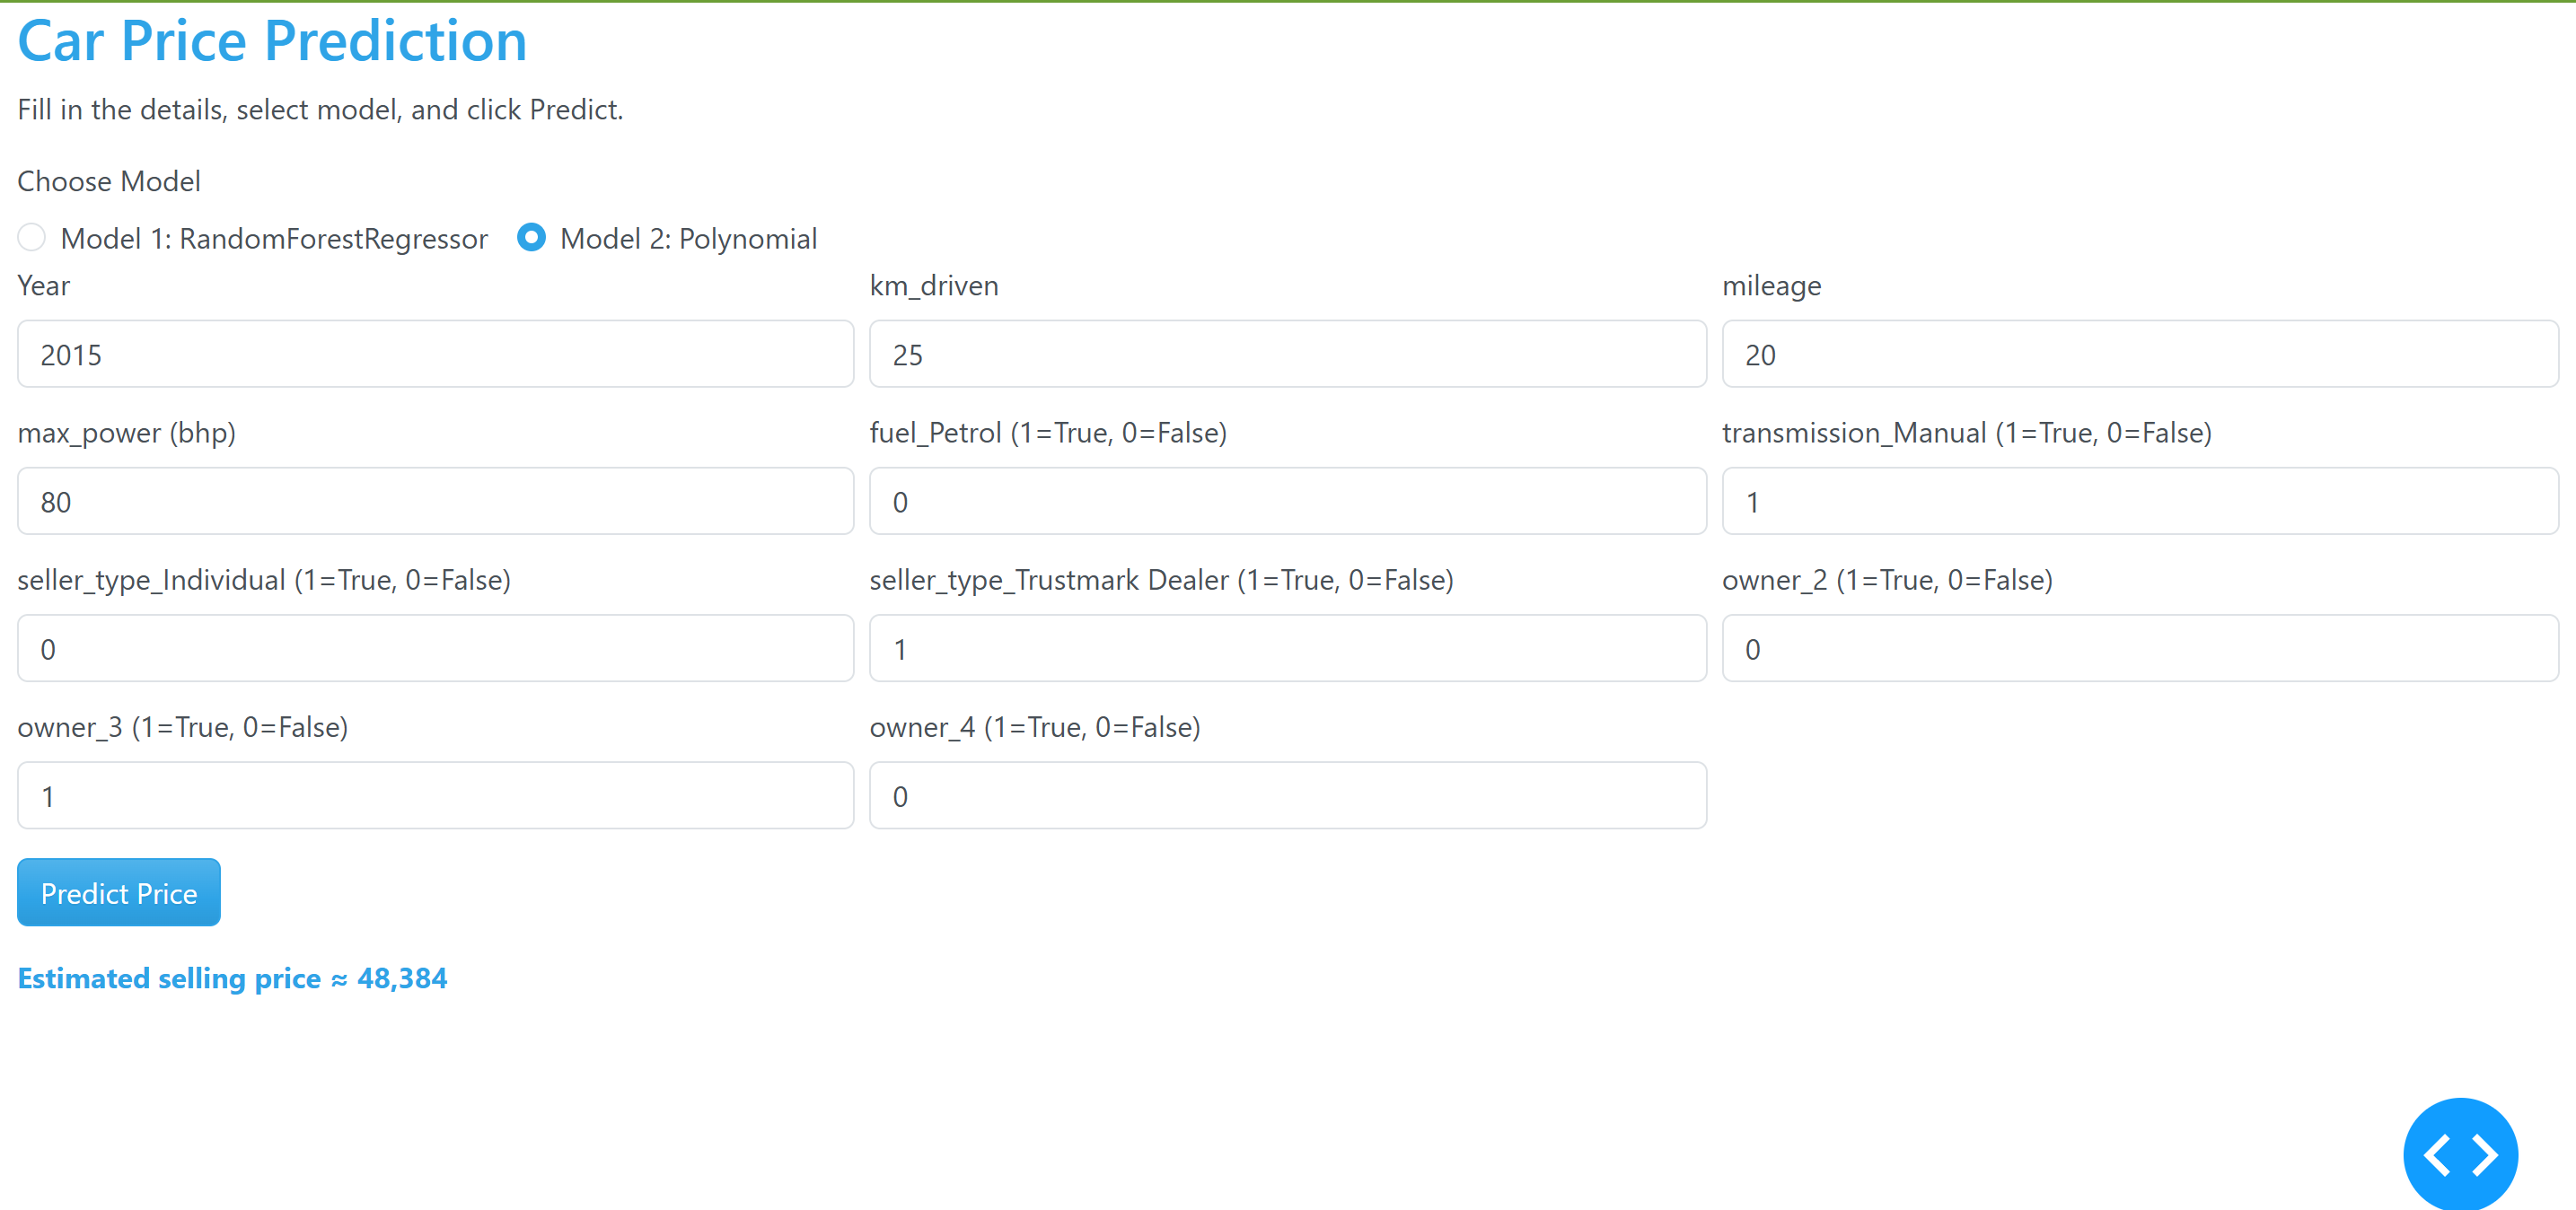

In [1]:
from IPython.display import Image, display

display(Image("assets/model1.png"))
display(Image("assets/model2.png"))

When I compared the results between the two models:

- Model 1: RandomForestRegressor

- Model 2: Polynomial Regression (degree = 2, batch gradient descent, learning rate = 0.01, Xavier initialization, not used momentum)

I found a very large gap in the predicted prices. RandomForest gave ≈ 511,231, while Polynomial Regression gave only ≈ 48,384. This suggests that RandomForest fits and generalizes better for this dataset, while Polynomial Regression may need feature scaling and careful tuning to work properly.

*P.S. In the future, I will check my code again to find the error in my process.*